In [1]:
import numpy as np
import mplhep as hep
import pickle

import os
import pandas as pd

import itertools
import sys
sys.path.insert(0, "../")

import matplotlib
import matplotlib.pyplot as plt

from utils.wafer import plot_wafer as plotWafer

from utils.metrics import emd
from utils.metrics import hexMetric

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, BatchNormalization, Activation, Average, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2
        
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

current_directory=os.getcwd()

def load_data(inputFile):
    noHeader=True

    # charge data headers of 48 Input Trigger Cells (TC) 
    CALQ_COLS = ['CALQ_%i'%c for c in range(0, 48)]

    if os.path.isdir(inputFile):
        df_arr = []
        for infile in os.listdir(inputFile):
            if os.path.isdir(inputFile+infile): continue
            infile = os.path.join(inputFile,infile)
            df_arr.append(pd.read_csv(infile, dtype=np.float64, header=0, usecols=[*range(0, 48)], names=CALQ_COLS))
        data = pd.concat(df_arr)
    else:
        data = pd.read_csv(inputFile)
        
    data = data.astype('float64')
    
    data_values = data.values
   
    return data_values

2021-07-28 16:54:24.453687: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#Take dataset from previous Autoencoder Training
csv_directory=os.path.join(current_directory,'test1','8x8_c8_S2_tele')
input_loc=os.path.join(csv_directory,'verify_input_calQ.csv')

q_input_data=load_data(input_loc)

print(q_input_data.shape)

remap_8x8 = [4, 12, 20, 28,  5, 13, 21, 29,  6, 14, 22, 30,  7, 15, 23, 31, 
             24, 25, 26, 27, 16, 17, 18, 19,  8,  9, 10, 11,  0,  1,  2,  3, 
             59, 51, 43, 35, 58, 50, 42, 34, 57, 49, 41, 33, 56, 48, 40, 32]

output_loc=os.path.join(csv_directory,'verify_decoded_calQ.csv')
ae_input_data=load_data(output_loc)
print(ae_input_data.shape)

(98024, 48)
(98024, 48)


In [3]:
#Get True EMD Values
indices = range(0, len(q_input_data))
emd_values = np.array([emd(q_input_data[i],ae_input_data[j]) for i, j in zip(indices,indices)])

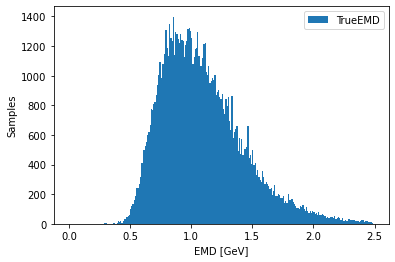

In [4]:
#Plot True EMD for input vs AE(input)

fig=plt.figure()
fig=plt.hist(emd_values, alpha=1, bins=np.arange(0, 2.5,0.01), label='TrueEMD')
fig=plt.xlabel('EMD [GeV]')
fig=plt.ylabel('Samples')
fig=plt.legend()
plt.savefig(os.path.join(current_directory,'TrueEMD.png'))
plt.show()

In [5]:
#Arranging the hexagon
arrange443 = np.array([0,16,32,
                        1,17,33,
                        2,18,34,
                        3,19,35,
                        4,20,36,
                        5,21,37,
                        6,22,38,
                        7,23,39,
                        8,24,40,
                        9,25,41,
                        10,26,42,
                        11,27,43,
                        12,28,44,
                        13,29,45,
                        14,30,46,
                        15,31,47])
        
calQ     = q_input_data
sumQ     = calQ.sum(axis=1)
calQ     = calQ[sumQ>0]
sumQ     = sumQ[sumQ>0]
    
calQ_443 = (calQ/np.expand_dims(sumQ,-1))[:,arrange443].reshape(-1,4,4,3)

calA     = ae_input_data
sumA     = tf.math.reduce_sum(calA, axis=1)
calA     = calA[sumA>0]
sumA     = sumA[sumA>0]
    
calA_443 = (calA/tf.expand_dims(sumA,-1))
r = tf.gather(calA_443, arrange443, axis=1)
r = tf.reshape(r, (-1, 4, 4, 3))
calA_443=r

print("Data Shapes")
print(calQ_443.shape)
print(calA_443.shape)


train_indices = range(0, int(0.6*len(calQ)))
val_indices = range(int(0.6*len(calQ)), len(calQ))

train_index=int(0.6*len(calQ))

idx1_train = np.array([i for i in train_indices])
idx2_train = np.array([j for j in train_indices])
              
X1 = calQ_443
X2 = calA_443
                 
X1_train = X1[0:train_index]
X2_train = X2[0:train_index]

y_train = np.array([emd(calQ[i],calA[j]) for i, j in zip(train_indices,train_indices)])

X1_val = X1[train_index:]
X2_val = X2[train_index:]
y_val = np.array([emd(calQ[i],calA[j]) for i, j in zip(val_indices, val_indices)])
    
print(X1_train.shape)
print(X2_train.shape)
print(y_train.shape)
    
print(X1_val.shape)
print(X2_val.shape)
print(y_val.shape)        


2021-07-28 16:55:09.657537: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-28 16:55:09.755572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3e:00.0 name: TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2021-07-28 16:55:09.755631: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-28 16:55:09.775580: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-28 16:55:09.775671: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-07-28 16:55:09.776880: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-

Data Shapes
(98024, 4, 4, 3)
(98024, 4, 4, 3)
(58814, 4, 4, 3)
(58814, 4, 4, 3)
(58814,)
(39210, 4, 4, 3)
(39210, 4, 4, 3)
(39210,)


In [6]:
#EMD CNN Hyperparamters
num_filt=32
kernel_size=5
num_dens_neurons=256
num_dens_layers=1
num_conv_2d=3

num_epochs=40

current_directory=os.getcwd()

#Building CNN
        
# make a convolutional model as a more advanced PoC
input1 = Input(shape=(4, 4, 3,), name='input_1')
input2 = Input(shape=(4, 4, 3,), name='input_2')
x = Concatenate(name='concat')([input1, input2])
            
#Number of Conv2D Layers
for i in range(1,num_conv_2d+1):
    ind=str(i)
    x = Conv2D(num_filt, kernel_size, strides=(1, 1), name='conv2d_'+ind, padding='same', kernel_regularizer=l1_l2(l1=0,l2=1e-4))(x)
    x = BatchNormalization(name='batchnorm_'+ind)(x)
    x = Activation('relu', name='relu_'+ind)(x)
                
x = Flatten(name='flatten')(x)
            
#Number of Dense Layers
for i in range(1,num_dens_layers+1):
    ind=str(i)
    jind=str(i+num_conv_2d)
    x = Dense(num_dens_neurons, name='dense_'+ind, kernel_regularizer=l1_l2(l1=0,l2=1e-4))(x)
    x = BatchNormalization(name='batchnorm'+jind)(x)
    x = Activation('relu', name='relu_'+jind)(x)
                
output = Dense(1, name='output')(x)
model = Model(inputs=[input1, input2], outputs=output, name='base_model')
model.summary()
                
final_directory=os.path.join(current_directory,r'emd_loss_models')
if not os.path.exists(final_directory):
        os.makedirs(final_directory)
callbacks = [ModelCheckpoint('emd_loss_models/'+str(num_filt)+str(kernel_size)+str(num_dens_neurons)+str(num_dens_layers)+str(num_conv_2d)+str(num_epochs)+'best.h5', monitor='val_loss', verbose=1, save_best_only=True),
                ModelCheckpoint('emd_loss_models/'+str(num_filt)+str(kernel_size)+str(num_dens_neurons)+str(num_dens_layers)+str(num_conv_2d)+str(num_epochs)+'last.h5', monitor='val_loss', verbose=1, save_last_only=True),
            ]
            
model.compile(optimizer='adam', loss='huber_loss', metrics=['mse', 'mae', 'mape', 'msle'])
history = model.fit((X1_train, X2_train), y_train, 
                    validation_data=((X1_val, X2_val), y_val),
                    epochs=num_epochs, verbose=1, batch_size=32, callbacks=callbacks)

Model: "base_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4, 3)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4, 4, 3)]    0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 4, 4, 6)      0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 4, 32)     4832        concat[0][0]            

2021-07-28 16:55:51.667917: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-28 16:55:51.680354: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3000000000 Hz


Epoch 1/40


2021-07-28 16:55:53.255711: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-28 16:55:54.364957: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-07-28 16:55:55.876248: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-28 16:55:56.887398: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


1838/1838 [==============================] - 18s 7ms/step - loss: 0.0652 - mse: 0.0730 - mae: 0.1867 - mape: 17.4190 - msle: 0.0141 - val_loss: 0.0379 - val_mse: 0.0346 - val_mae: 0.1518 - val_mape: 13.9071 - val_msle: 0.0081

Epoch 00001: val_loss improved from inf to 0.03792, saving model to emd_loss_models/3252561340best.h5

Epoch 00001: saving model to emd_loss_models/3252561340last.h5
Epoch 2/40
1838/1838 [==============================] - 13s 7ms/step - loss: 0.0282 - mse: 0.0281 - mae: 0.1292 - mape: 12.1743 - msle: 0.0059 - val_loss: 0.0148 - val_mse: 0.0109 - val_mae: 0.0797 - val_mape: 7.6257 - val_msle: 0.0025

Epoch 00002: val_loss improved from 0.03792 to 0.01476, saving model to emd_loss_models/3252561340best.h5

Epoch 00002: saving model to emd_loss_models/3252561340last.h5
Epoch 3/40
1838/1838 [==============================] - 13s 7ms/step - loss: 0.0184 - mse: 0.0231 - mae: 0.1176 - mape: 11.1331 - msle: 0.0049 - val_loss: 0.0152 - val_mse: 0.0200 - val_mae: 0.1202 - 

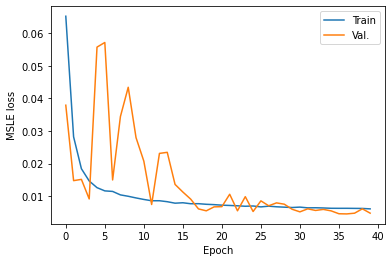

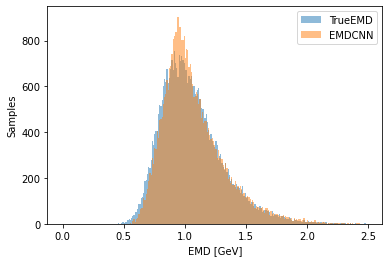

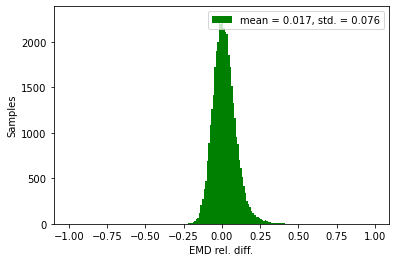

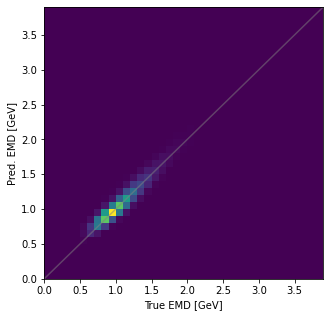

In [8]:
#Making directory for graphs
        
img_directory=os.path.join(current_directory,r'Performance on Predicting True EMD')
if not os.path.exists(img_directory):
    os.makedirs(img_directory)
        
#Plot Validation loss and training loss
        
plt.close()
fig=plt.plot(history.history['loss'], label='Train')
fig=plt.plot(history.history['val_loss'], label='Val.')
fig=plt.xlabel('Epoch')
fig=plt.ylabel('MSLE loss')
fig=plt.legend()
plt.savefig(img_directory+"/"+str(num_filt)+str(kernel_size)+str(num_dens_neurons)+str(num_dens_layers)+str(num_conv_2d)+str(num_epochs)+"Loss.png")
plt.show()
plt.close()
        
#Plots True EMD and Pred Emd Histogram
        
plt.close()
y_val_preds = model.predict((X1_val, X2_val))
fig=plt.figure()
fig=plt.hist(y_val, alpha=0.5, bins=np.arange(0, 2.5,0.01), label='TrueEMD')
fig=plt.hist(y_val_preds, alpha=0.5, bins=np.arange(0, 2.5,0.01), label='EMDCNN')
fig=plt.xlabel('EMD [GeV]')
fig=plt.ylabel('Samples')
fig=plt.legend()
fig=plt.savefig(img_directory+"/"+str(num_filt)+str(kernel_size)+str(num_dens_neurons)+str(num_dens_layers)+str(num_conv_2d)+str(num_epochs)+"Hist.png")
plt.show()
plt.close()
        
#Plot Relative Difference
        
plt.close()
rel_diff = (y_val_preds[y_val>0].flatten()-y_val[y_val>0].flatten())/y_val[y_val>0].flatten()
fig=plt.figure()
fig=plt.hist(rel_diff, bins=np.arange(-1, 1, 0.01), color='green', label = 'mean = {:.3f}, std. = {:.3f}'.format(np.mean(rel_diff), np.std(rel_diff)))
fig=plt.xlabel('EMD rel. diff.')
fig=plt.ylabel('Samples')
fig=plt.legend()
fig=plt.savefig(img_directory+"/"+str(num_filt)+str(kernel_size)+str(num_dens_neurons)+str(num_dens_layers)+str(num_conv_2d)+str(num_epochs)+"RelD.png")
plt.show()
plt.close()
        
#Plot True EMD vs Pred Emd Graphic
        
plt.close()
fig, ax = plt.subplots(figsize =(5, 5)) 
x_bins = np.arange(0, 4, 0.1)
y_bins = np.arange(0, 4, 0.1)
plt.hist2d(y_val.flatten(), y_val_preds.flatten(), bins=[x_bins,y_bins])
plt.plot([0, 15], [0, 15], color='gray', alpha=0.5)
ax.set_xlabel('True EMD [GeV]')
ax.set_ylabel('Pred. EMD [GeV]')
fig=plt.savefig(img_directory+"/"+str(num_filt)+str(kernel_size)+str(num_dens_neurons)+str(num_dens_layers)+str(num_conv_2d)+str(num_epochs)+"Graphic.png")
plt.show()
plt.close()